# About

This program downloads, manages, and exports to .csv files inflation forecast data from the Federal Reserve Bank of Philadelphia and actual inflation and interest rate data from FRED. The purpose is to learn about historical *ex ante* real interest rates in the US.

Inflation is computed in the *forward* direction so that it aligns with the interest and forecast data. For quarterly deflator data:
\begin{align}
\pi_t & = 100 \cdot \left(P_{t+4}/P_t-1\right)
\end{align}
And for annual data:
\begin{align}
\pi_t & = 100 \cdot \left(P_{t+1}/P_t-1\right)
\end{align}

In [1]:
import numpy as np
import pandas as pd
import fredpy as fp
import matplotlib.pyplot as plt
import mock
from openpyxl.reader import excel

plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Download and manage forecast data

GDP deflator forecasts are available from the Survey of Professional Forecasters:

https://www.philadelphiafed.org/surveys-and-data/pgdp

The code below downloads and imports the median forecasts for the level of the GDP quarterly_data. The Excel file is called `Median_PGDP_Level.xlsx` and has the following columns:

* `YEAR` and `QUARTER`
* `PGDP1`: The actual GDP defator for the quarter
* `PGDP2`: The contemporaneous estimate of the GDP deflator for the quarter
* `PGDP3`, `PGDP4`, `PGDP5`, `PGDP6`: 1, 2, 3, 4 quarter ahead forecasts of the deflator
* `PGDPA`, `PGDPB`: annual-average projections for the year the survey was administered and the following year.

Documentation on the data is here:

https://www.philadelphiafed.org/-/media/FRBP/Assets/Surveys-And-Data/survey-of-professional-forecasters/spf-documentation.pdf?sc_lang=en&hash=8408A4F1BF351A3C268B40F6BC7B95AA

In [2]:
with mock.patch.object(excel.ExcelReader, 'read_properties', lambda self: None):
    data = pd.read_excel('https://www.philadelphiafed.org/-/media/FRBP/Assets/Surveys-And-Data/survey-of-professional-forecasters/data-files/files/Median_PGDP_Level.xlsx?sc_lang=en&hash=52CF485F367422E0E5C561071BD0D9CA', dtype={'YEAR': str, 'QUARTER': str},sheet_name='Median_Level')

# Fill in missing values for PGDP6 column for 1969:1-3 and 1970:1
data['PGDP6'] = data['PGDP6'].interpolate()

# Create a datetime index
y = data.loc[0,'YEAR']
q = data.loc[0,'QUARTER']
m = str(3*(int(q)-1)+1)

dates = pd.date_range(start = m+'-1-'+y,periods=len(data.index),freq='QS')
data.index = dates

# Drop pre-1970 values
data = data.loc['1970':]

# Drop unnnecessary columns
data = data.drop(['YEAR','QUARTER','PGDP3','PGDP4','PGDP5','PGDPA','PGDPB'],axis=1)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Quarterly data

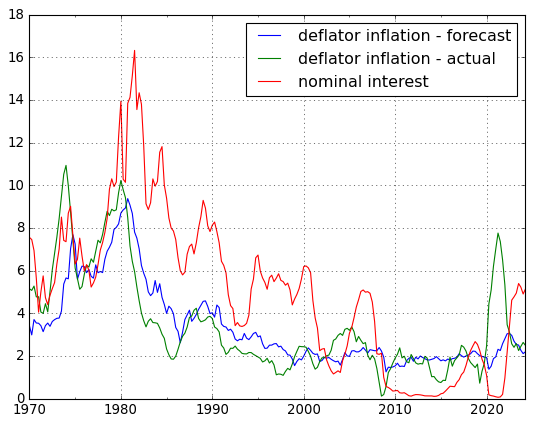

In [3]:
quarterly_data = pd.DataFrame()

inflation_forecast = 100*(data['PGDP6']/data['PGDP2']-1)
quarterly_data['deflator inflation - forecast'] = inflation_forecast#.shift(4)

deflator = fp.series('GDPDEF').data
inflation = 100*(deflator.shift(-4)/deflator-1)
quarterly_data['deflator inflation - actual'] = inflation

interest1yr = fp.series('GS1').data.resample('QS').mean()
quarterly_data['nominal interest'] = interest1yr#.shift(4)

quarterly_data = quarterly_data.dropna()

quarterly_data.to_csv('../csv/real_rate_data_quarterly.csv',index=True)

quarterly_data.plot()

plt.grid()

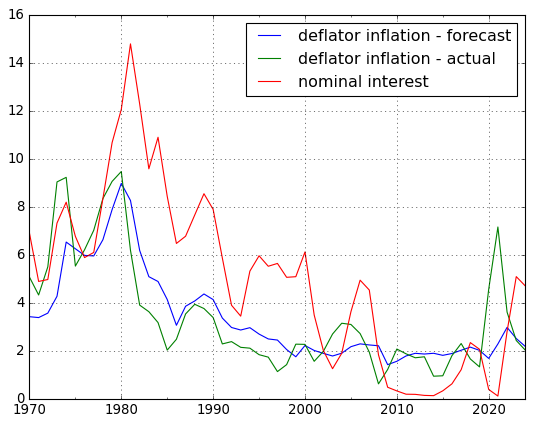

In [4]:
data = data.resample('YS').mean()

annual_data = pd.DataFrame()

inflation_forecast = 100*(data['PGDP6']/data['PGDP2']-1)
annual_data['deflator inflation - forecast'] = inflation_forecast#

deflator = fp.series('GDPDEF').data.resample('YS').mean()
inflation = 100*(deflator.shift(-1)/deflator-1)
annual_data['deflator inflation - actual'] = inflation

interest1yr = fp.series('GS1').data.resample('YS').mean()
annual_data['nominal interest'] = interest1yr#.shift(1)

annual_data = annual_data.dropna()

annual_data.plot()
plt.grid()

annual_data.to_csv('../csv/real_rate_data_annual.csv',index=True)

## Plots

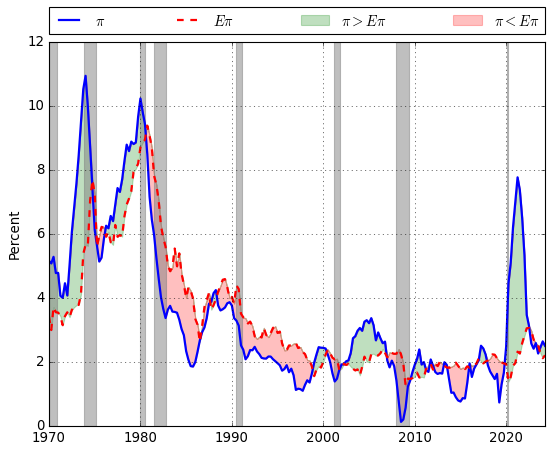

In [5]:
# Figure for website
fig,ax = plt.subplots()
ax.plot(quarterly_data['deflator inflation - actual'],'-b',lw=2,label='$\\pi$')
ax.plot(quarterly_data['deflator inflation - forecast'],'--r',lw=2,label='$E\\pi$')
ax.fill_between(quarterly_data.index,quarterly_data['deflator inflation - forecast'],np.max([quarterly_data['deflator inflation - actual'],quarterly_data['deflator inflation - forecast']],axis=0),color='g',alpha=0.25,label='$\\pi>E\\pi$')
ax.fill_between(quarterly_data.index,np.max([quarterly_data['deflator inflation - actual'],quarterly_data['deflator inflation - forecast']],axis=0),quarterly_data['deflator inflation - actual'],color='r',alpha=0.25,label='$\\pi<E\\pi$')
fp.recessions(start=quarterly_data.index[0],end=quarterly_data.index[-1])
ax.grid()
ax.set_ylabel('Percent')

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4,borderaxespad=0., mode="expand",fontsize=13)

plt.savefig('../png/fig_US_Inflation_Forecast_site.png',bbox_inches='tight')

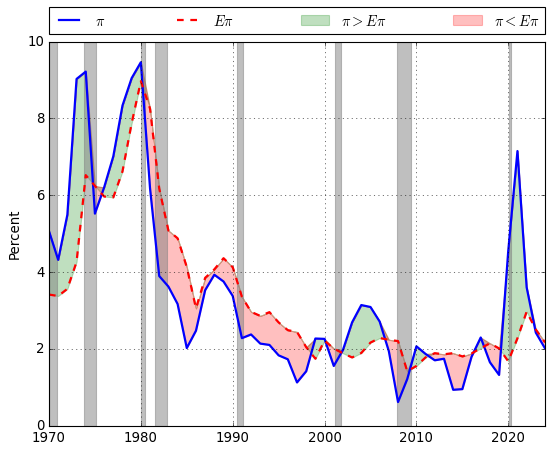

In [6]:
# Same figure as above, but with annual data
fig,ax = plt.subplots()
ax.plot(annual_data['deflator inflation - actual'],'-b',lw=2,label='$\\pi$')
ax.plot(annual_data['deflator inflation - forecast'],'--r',lw=2,label='$E\\pi$')
ax.fill_between(annual_data.index,annual_data['deflator inflation - forecast'],np.max([annual_data['deflator inflation - actual'],annual_data['deflator inflation - forecast']],axis=0),color='g',alpha=0.25,label='$\\pi>E\\pi$')
ax.fill_between(annual_data.index,np.max([annual_data['deflator inflation - actual'],annual_data['deflator inflation - forecast']],axis=0),annual_data['deflator inflation - actual'],color='r',alpha=0.25,label='$\\pi<E\\pi$')
fp.recessions(start=annual_data.index[0],end=annual_data.index[-1])
ax.grid()
ax.set_ylabel('Percent')

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4,borderaxespad=0., mode="expand",fontsize=13);

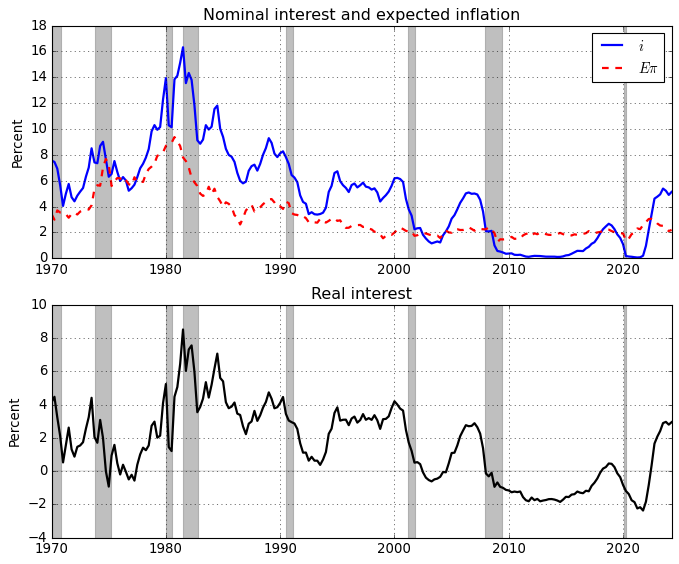

In [7]:
# Nominal rate, real rate, and expected inflation
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(2,1,1)
ax.plot(quarterly_data['nominal interest'],label='$i$',lw=2)
ax.plot(quarterly_data['deflator inflation - forecast'],'r--',label='$E\\pi$',lw=2)
ax.set_title('Nominal interest and expected inflation')
fp.recessions(start=quarterly_data.index[0],end=quarterly_data.index[-1])
ax.set_ylabel('Percent')
ax.grid()

ax.legend(loc='upper right',ncol=1,fontsize=13)

ax = fig.add_subplot(2,1,2)
ax.plot(quarterly_data['nominal interest']-quarterly_data['deflator inflation - forecast'],'k',lw=2)
ax.plot(quarterly_data['nominal interest']*0,'k',lw=0.15)
fp.recessions(start=quarterly_data.index[0],end=quarterly_data.index[-1])
ax.set_title('Real interest')
ax.set_ylabel('Percent')
ax.grid()

In [8]:
# ## Delete SPF data files
# try:
#     os.remove('../xlsx/inflation.xlsx')
# except:
#     pass